#### POISSON EQUATION 1D
Let $\Omega = (-1, 1)$ and $f \in L^2(\Omega), g \in H^{1/2}(\partial\Omega)$:

$$
    \begin{cases}
        \begin{array}{rl}
            \Delta u + f &= 0 \text{ in } \Omega, \\
            u &= g \text{ on } \partial \Omega.
        \end{array}
    \end{cases}
$$

#### PDE DATA
Let $\lambda_0, \lambda_1, \beta_0, \beta_1, \omega > 0$ and $\lambda_0 = 2 \pi \omega$:

$$
    \begin{split}
        f(x) &= \beta_0 \lambda_0^2 sin(\lambda_0 x) + 2\beta_1 \lambda_1^2 (sinh(\lambda_1 x) \ / \ cosh(\lambda_1 x)^3)),\\
        g(x) &= \beta_0 \sin(\lambda_0 x) + \beta_1 \tanh(\lambda_1 x).
    \end{split}
$$

#### EXPERIMENTS

Experiment 1: $\lambda_0 = 30\pi$, $\beta_1 = 0.01$, $\lambda_1 = 0$, $\beta_1 = 0.1$, $p = \infty$;

Experiment 2: $\lambda_0 = 30\pi$, $\beta_1 = 0.01$, $\lambda_1 = 50$, $\beta_1 = 0.1$, $p = \infty$;

In [1]:
import numpy as np
import sys
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_1d, leg_bary, laplacian, inverse_lu
prefix = None #"poisson_equation_1d"

#### CUBATURE AND DIFFERENTIATION

In [2]:
deg = 100
cuba = Cubature([deg], points="Legendre") # for Lobatto points choose points="Lobatto"
w = cuba.leja_weights
xs = cuba.leja_axes
xs_plt = cuba.axes
bary = cuba.leja_axes_bary
diff = Differentiation(xs, bary)
dx = diff.nabla[0]
dx2 = diff.diffs(np.array([[2]]))[0]

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w))
n_d = deg+1

W = np.diag(w)
W_inv = np.linalg.inv(W)

M_1, M_1_inv = laplacian([dx], [W_inv], [W])
M_1_s, _ = laplacian([dx], [W_inv], [W], weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.14876849764118516
0.08469518420664746


$$
    f(x) = C \cdot (A \omega^2 sin(\omega x) + 2 \beta^2 (sinh(\beta x) \ / \ cosh(\beta x)^3))
$$

#### PDE DATA

In [5]:
lam_0 = 30.0*np.pi
beta_0 = 0.01
lam_1 = 0.0
beta_1 = 0.1

def f(x):
    return beta_0*lam_0**2*np.sin(lam_0*x) + \
            2*beta_1*lam_1**2*np.sinh(lam_1*x)/np.cosh(lam_1*x)**3

def gt(x):
    return beta_0*np.sin(lam_0*x)+beta_1*np.tanh(lam_1*x)

#### BENCHMARK INITIALIZATION

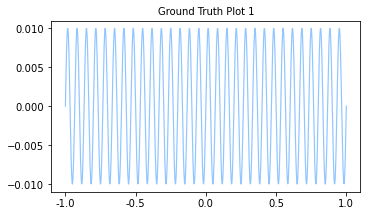

L^2 norm: 0.007067534927402195
L^inf norm: 0.01


In [6]:
test_xs = np.linspace(-1.0, 1.0, 1001)
data = data_1d(test_xs, deg).T
bm = Benchmark(gt, [test_xs], data)
eval_gt = bm.eval_gt()
bm.plot_gt(prefix=prefix)
print(f'L^2 norm: {np.mean(np.array(eval_gt)**2)**0.5}')
print(f'L^inf norm: {np.max(abs(np.array(eval_gt)))}')

#### PDE DATA RESOLUTION

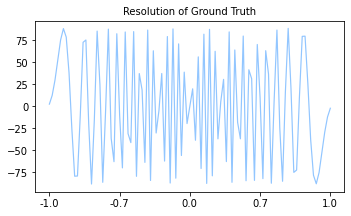

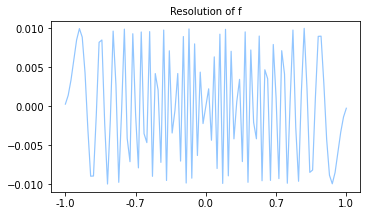

In [7]:
gt_plt = gt(xs_plt[0])
f_plt = f(xs_plt[0])

f_fn = None#f'{prefix}_pde_data_res_f'
gt_fn = None#f'{prefix}_pde_data_res_gt'

bm.plot1d(f_plt, xs_plt[0], title="Resolution of Ground Truth", file_name=f_fn)
bm.plot1d(gt_plt, xs_plt[0], title="Resolution of f", file_name=gt_fn)

#### REGRESSION UTILITIES

In [8]:
crnrs = np.array([-1.0, 1.0])

C_d = data_1d(xs[0], deg).T
C_b = data_1d(crnrs, deg).T

gt_b = np.array([gt(crnrs[0]), gt(crnrs[1])])
fX = np.array(f(xs[0]))

#### DUAL LSQ FORMULATION

In [9]:
def metric(m): return lambda x: matmul(m,x)*x
T=dx2
L = lambda u_d, u_b, metric, lam=1.0:\
    sum(w*metric(matmul(T, u_d)+fX))+lam*sum((u_b-gt_b)**2)

#### TRUNCATION ERROR

In [10]:
args = [gt(xs[0]), gt_b]
trunc_err = {
    "L_l2"   : L(*args, metric(I)),
    "L_"     : L(*args, metric(M_1), 1),
    "L_s"    : L(*args, metric(M_1_s), 1),
    "L_mod"  : L(*args, metric(M_1_mod), n_d),
    "L_s_mod": L(*args, metric(M_1_s_mod), n_d)}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 91460.35478066209,
     "L_": 40.56768484792931,
     "L_s": 0.010342277032498771,
     "L_mod": 49.53350729481316,
     "L_s_mod": 1.0445699802823905
}


#### SOLUTION

In [11]:
def solution(m1, m2, lam=1.0):
    E = matmul(C_d.T, W, m2, C_d)
    TC_d = matmul(T, C_d)
    TC_d_s = matmul(E, TC_d.T, W, m1)
    C_b_s = matmul(E, lam*C_b.T)
    T_sT_inv = inverse_lu(matmul(TC_d_s, TC_d)+matmul(C_b_s, C_b))
    T_sf = matmul(TC_d_s, -fX)+matmul(C_b_s, gt_b)
    theta = matmul(T_sT_inv, T_sf)
    theta = theta.reshape(len(theta),-1)
    return lambda X: np.matmul(np.array(X), theta)

In [12]:
cheb_l2 = solution(I, I)

cheb_ = solution(M_1, M_1_inv, lam=1)
cheb_s = solution(M_1_s, M_1_inv, lam=1)

cheb_mod = solution(M_1_mod, M_1_inv, lam=n_d)
cheb_s_mod = solution(M_1_s_mod, M_1_inv, lam=n_d)

In [13]:
# SET MODELS #
bm.set_model([cheb_l2, cheb_, cheb_s, cheb_mod, cheb_s_mod])

#### MODEL EVALUATION AND PLOT

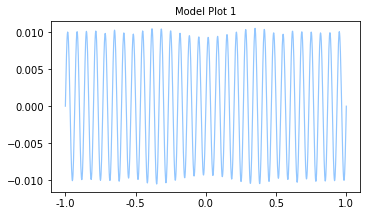

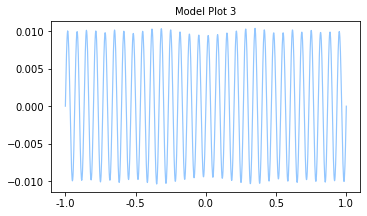

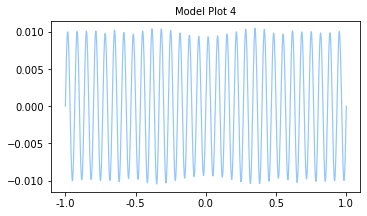

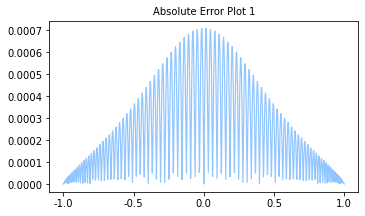

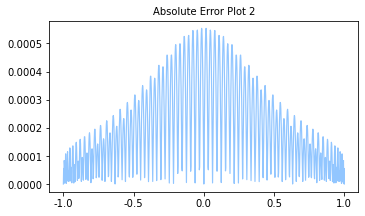

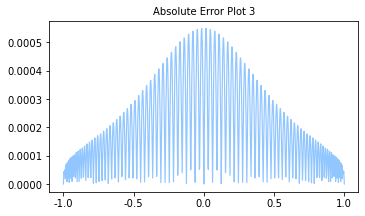

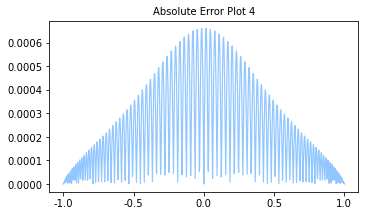

In [14]:
_ = bm.eval_model()
bm.plot_model(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERROR

In [15]:
print(f'L1  Error: {bm.lp_err(1, precision=3)}')
print(f'L2  Error: {bm.lp_err(2, precision=3)}')
print(f'Max Error: {bm.lp_err(np.inf, precision=3)}')

L1  Error: ['2.382e-04', '1.995e-04', '1.969e-04', '2.294e-04', '1.969e-04']
L2  Error: ['3.078e-04', '2.469e-04', '2.441e-04', '2.917e-04', '2.441e-04']
Max Error: ['7.094e-04', '5.537e-04', '5.499e-04', '6.607e-04', '5.499e-04']


#### TABLE FORMAT ERROR

In [16]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg} '
for _ in err.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'

print(row)

100 & 3.08e-04 & 7.09e-04 & 2.47e-04 & 5.54e-04 & 2.44e-04 & 5.5e-04 & 2.92e-04 & 6.61e-04 & 2.44e-04 & 5.5e-04 \\
